In [ ]:
# After the notebook, generate requirements.txt
!pip freeze > requirements.txt

We'll start with downloading the dependencies.

In [ ]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 5.1 MB/s eta 0:00:00


Next, let's import libraries.

In [ ]:
# import the necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

from collections import defaultdict
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import contractions
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


# nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

# wordcloud
from wordcloud import WordCloud

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, get_scorer, f1_score, roc_auc_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

# filter warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# import gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.models import Word2Vec as GensimWord2Vec
from gensim.models import LdaModel

import multiprocessing
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
# import libraries
from google.colab import files
from google.colab import drive

Working with Google Colab, its best to mount Google Drive as that let's you easy save and access files, especially in case of session crash.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Original Data Source: https://www.kaggle.com/datasets/hiraddolatzadeh/bitcoin-tweets-2021-2022/data

Importing the original dataframe stored on Google Drive.

In [ ]:
# Path to CSV file in Google Drive
csv_file_path = '/content/gdrive/MyDrive/Capstone/bitcoin-tweets-2021.csv'

# Read the CSV file into a DataFrame
df1 = pd.read_csv(csv_file_path, lineterminator='\n', parse_dates=['datetime'])

In [ ]:
# Path to CSV file in Google Drive
csv_file_path = '/content/gdrive/MyDrive/Capstone/bitcoin-tweets-2022.csv'

# Read the CSV file into a DataFrame
df2 = pd.read_csv(csv_file_path, lineterminator='\n', parse_dates=['datetime'])

What do df1 & df2 look like?

In [ ]:
# Let's look at df1 head
df1.head()

,datetime,username,text
0,2021-01-01 23:59:58+00:00,WoodooProd,Crypto adoption in 2021: Top trends and predic...
1,2021-01-01 23:59:53+00:00,YSojourners,Ripple Executive Says US Laws on Crypto Are Va...
2,2021-01-01 23:59:53+00:00,Andama_n,@hextoysofficial | https://t.co/C6LPpuq05n Are...
3,2021-01-01 23:59:51+00:00,YSojourners,FUN and Games: Altcoin Drastically Pumps And D...
4,2021-01-01 23:59:50+00:00,HunnerSa,I bought #Bitcoin at 6k-8k-9k-12k-16k-19k and ...


In [ ]:
# Let's look at df2 head
df2.head()

,datetime,date,username,text
0,2022-01-01 23:59:56+00:00,2022-01-01,priconoticias,0.4MOT TOKENS IN #LATOKEN airdrop and maybe m...
1,2022-01-01 23:59:53+00:00,2022-01-01,mmonlineonline,MARA for Bitcoin Exposure: Top Trade Q1 2022 h...
2,2022-01-01 23:59:43+00:00,2022-01-01,CoachKevinRose,Every Time the Bell Rings The Titano makes MON...
3,2022-01-01 23:59:35+00:00,2022-01-01,robert54177167,If your interested in losing money in 2022 kee...
4,2022-01-01 23:59:34+00:00,2022-01-01,WorldCoinIndex,Bitcoin price index https://t.co/o7UcHJUhC6 #U...


Our dataframe is large with around 22 million tweets and so its available in two separate files, we'll need to concatinate the two files.

In [ ]:
# concatinating the two dataframes into one
tweets = pd.concat([df1, df2.drop('date', axis=1)], axis=0).sort_values(by=['datetime'], ignore_index=True).reset_index(drop=True)
print(len(tweets))

22907548


Social media is inflitrated by bots and fake accounts now a days and so its important to filter out advertisements from our corpus. We'll do that by defining what are "noise words" for us.

In [ ]:
# noise words are words usually used by advertisements
noise_words = ['free', 'freebitcoin', 'freeminingsoftware', 'freebitco', 'free bitcoin', 'makemoney', 'make money',
          'abtcl', 'tradingtool', 'trading tool', 'residualbitcoin', 'faucet', 'casino',
          'simplefx', 'nitrogensportsbook', 'makeyourownlane', 'bet', 'bitcoinbet', 'webbot', 'win', 'game', 'lottery',
          'bitcoinprice','bitcoin price' , 'mpgvip', 'footballcoin', 'earnbitcoin', 'earn bitcoin',
           'trading', 'price', 'performing currency', 'altcoin', 'fintech', 'pic']

Now, we can move to cleaning our corpus. Below is a funnel for the same.

In [ ]:
# Step 1: Data Inspection
print("Step 1: Data Inspection")
print("Initial Data Shape:", tweets.shape)

# Step 2: Data Cleaning Steps

# Step 2.1: Handle Missing Data
tweets.dropna(inplace=True)

print("Step 2.1: Handle Missing Data")
print("Data Shape after Handling Missing Data:", tweets.shape)

# Step 2.2: Convert Text to Lowercase
tweets["text"] = tweets["text"].str.lower()
print("Step 2.2: Convert Text to Lowercase")
print("Data Shape after Converting Text to Lowercase:", tweets.shape)

# Step 2.3: Remove Tweets with Noise Words
tweets = tweets[~tweets.text.str.contains('|'.join(noise_words))]
print("Step 2.3: Remove Tweets with Noise Words")
print("Data Shape after Removing Tweets with Noise Words:", tweets.shape)

# Step 2.4: Filter Tweets Containing 'bitcoin'
tweets_bitcoin = tweets[tweets['text'].str.contains('bitcoin')]
print("Step 2.4: Filter Tweets Containing 'bitcoin'")
print("Data Shape after Filtering Tweets Containing 'bitcoin':", tweets_bitcoin.shape)

# Remove Duplicates
if 'text' in tweets_bitcoin.columns:
    # Step 2.5: Remove Duplicate Tweets
    tweets_bitcoin = tweets_bitcoin.drop_duplicates(subset="text", keep="first")
    print("Step 2.5: Remove Duplicate Tweets")
    print("Data Shape after Removing Duplicate Tweets:", tweets_bitcoin.shape)

    # Step 2.6: Remove Tweets with Specified Phrases
    phrases_to_remove = ['new year', 'happy new year', 'new_year', 'happynewyear']
    mask = ~tweets_bitcoin['text'].str.contains('|'.join(phrases_to_remove))
    tweets_bitcoin = tweets_bitcoin[mask]
    print("Step 2.6: Remove Tweets with Specified Phrases")
    print("Final Data Shape after All Cleaning Steps:", tweets_bitcoin.shape)
else:
    print("Step 2.5: 'text' column not found in DataFrame. Check previous steps.")

# Step 2.7: Filter Out Rows

# Ensure that 'datetime' is in the correct pandas datetime format
tweets_bitcoin['datetime'] = pd.to_datetime(tweets_bitcoin['datetime'])

# Exclude rows
tweets_bitcoin = tweets_bitcoin[~tweets_bitcoin['datetime'].dt.year.isin([2020])]
print("Step 2.7: Filter Out Rows Not From 2021 or 2022")
print("Data Shape after Excluding Year 2020:", tweets_bitcoin.shape)

# Reset Index
tweets_bitcoin.reset_index(drop=True, inplace=True)

# Check tweets_bitcoin
tweets_bitcoin.head()

Step 1: Data Inspection
Initial Data Shape: (22907548, 3)
Step 2.1: Handle Missing Data
Data Shape after Handling Missing Data: (22907547, 3)
Step 2.2: Convert Text to Lowercase
Data Shape after Converting Text to Lowercase: (22907547, 3)
Step 2.3: Remove Tweets with Noise Words
Data Shape after Removing Tweets with Noise Words: (17464334, 3)
Step 2.4: Filter Tweets Containing 'bitcoin'
Data Shape after Filtering Tweets Containing 'bitcoin': (17436205, 3)
Step 2.5: Remove Duplicate Tweets
Data Shape after Removing Duplicate Tweets: (16586415, 3)
Step 2.6: Remove Tweets with Specified Phrases
Final Data Shape after All Cleaning Steps: (16575855, 3)
Step 2.7: Filter Out Rows Not From 2021 or 2022
Data Shape after Excluding Year 2020: (16575855, 3)


,datetime,username,text
0,2021-01-01 00:00:02+00:00,CryptoNetDaily,"new #crypto daily candle! 🕯️\n $btc $28,936..."
1,2021-01-01 00:00:04+00:00,WSJ,high fees and volatility present obstacles to ...
2,2021-01-01 00:00:06+00:00,awesomepersona2,do you own any cryptocurrency like #bitcoin \n...
3,2021-01-01 00:00:07+00:00,JeremyKissel,"ethereum posts 450% gain in 2020, beats bitcoi..."
4,2021-01-01 00:00:07+00:00,vpaul8483,@cashapp i love bitcoin!!! $matt121991


The column 'datetime' is not easy to read, we'll go ahead and split it.

In [ ]:
# Function for column funnel
def column_funnel(data):
    # Extract day, month, year, and time
    data['day'] = data['datetime'].dt.day
    data['month'] = data['datetime'].dt.month
    data['year'] = data['datetime'].dt.year
    data['time'] = data['datetime'].dt.time

    # Rename the column 'text' to 'tweet'
    data = data.rename(columns={'text': 'tweet'})

    # Rearrange columns
    data = data[['year', 'month', 'day', 'time', 'datetime', 'username', 'tweet']]

    return data

# Apply the column funnel to DataFrame (tweets_bitcoin)
tweets_bitcoin = column_funnel(tweets_bitcoin)

# Display the shape of the cleaned DataFrame
print("Shape of tweets_bitcoin:", tweets_bitcoin.shape)

Shape of tweets_bitcoin: (16575855, 7)


Let's get the maximum view possible.

In [ ]:
# Set the option to display full content in a column
pd.set_option('display.max_colwidth', None)

In [ ]:
# Let's look at the dataframe
tweets_bitcoin.head()

,year,month,day,time,datetime,username,tweet
0,2021,1,1,00:00:02,2021-01-01 00:00:02+00:00,CryptoNetDaily,"new #crypto daily candle! 🕯️\n $btc $28,936.00 (+0.28%)\n $eth $738.42 (-1.92%)\n $xrp $0.2205 (+3.83%)\n $ltc $124.81 (-3.26%)\n #bitcoin dominance: 69.45%\n fng: 95 extreme greed"
1,2021,1,1,00:00:04,2021-01-01 00:00:04+00:00,WSJ,"high fees and volatility present obstacles to the soaring bitcoin becoming a payments staple, but paypal’s decision to allow customers to buy and sell the digital currency could be a step toward the mainstream https://t.co/7uj2eztsjh"
2,2021,1,1,00:00:06,2021-01-01 00:00:06+00:00,awesomepersona2,do you own any cryptocurrency like #bitcoin \n\n it's only safe in your private wallet \n\n get the best wallet here \n\n https://t.co/lcez1queqy
3,2021,1,1,00:00:07,2021-01-01 00:00:07+00:00,JeremyKissel,"ethereum posts 450% gain in 2020, beats bitcoin | finance magnates https://t.co/b0sjfnkar6"
4,2021,1,1,00:00:07,2021-01-01 00:00:07+00:00,vpaul8483,@cashapp i love bitcoin!!! $matt121991


Given the limitations on time and resources, we'll work with a sample.

In [ ]:
# defining sample size
sample_size = 1000000

# Take a random sample of 1 million tweets
sample_tweets = tweets_bitcoin.sample(n=sample_size, random_state=42)

# Display the shape of sample DataFrame
print(sample_tweets.shape)

(1000000, 7)


Going forward, we'll be saving files, models etc on Google Drive in case of session crash and thus these files can then we retrieved from Drive for a new session and we'll not have to repeat our work.

In [ ]:
# Define the directory
output_dir = '/content/gdrive/MyDrive/Capstone/Word2Vec/sample_tweets/'

# Define the file name
file_name = 'sample_tweets.csv'

# Save the DataFrame to a CSV file in Google Drive
sample_tweets.to_csv(output_dir + file_name, index=False)

In [ ]:
# Retrieve in case of session crash
csv_path = '/content/gdrive/MyDrive/Capstone/Word2Vec/sample_tweets/sample_tweets.csv'

# Load the DataFrame
sample_tweets = pd.read_csv(csv_path, lineterminator='\n')

In [ ]:
# Let's look at head of our new dataframe
sample_tweets.head()

,year,month,day,time,datetime,username,tweet
0,2022,6,22,17:20:08,2022-06-22 17:20:08+00:00,dasrecord,@allen_drewe @financebrah2 @newzealandhodl @florida_btc @ln_prints @awaitedsavior @ropeium @theguyswann @downwarddave @davidgshort @rangershodl @based_fyodor @federalistfiles @notephesians @mr_vril_maxxed @bitcoin_fuckboi @andhans_jail @janetystackx @joshmanmode_ you mean your fiat is slowly dying.
1,2021,7,4,17:35:49,2021-07-04 17:35:49+00:00,CryptoEugene101,"@themoonboyz \n\n$qnt “the image below explains \n what quant is all about!”\n\n“expect a parabolic breakout!”\n\n“$qnt is all around us &amp; the majority don’t even realise/ know it yet, but soon they will!”\n\n@quant_network @quantoverledger \n@ripple @bitcoin https://t.co/nqqfe8fw6c"
2,2021,9,8,17:05:41,2021-09-08 17:05:41+00:00,BotcoinUSD,on the 09/08/2021 at 05:05 1btc was worth $46377.00 #bitcoin #crypto #botcoinusd #bitfinex
3,2021,4,23,09:49:48,2021-04-23 09:49:48+00:00,emylacapra,"@shanstory the best position is to love both when it goes up or down😉\nit's never enough of bitcoin bought, don't you think?"
4,2021,5,3,04:14:42,2021-05-03 04:14:42+00:00,x_rhodium,@xrpology you’ll have to forgive me because it’s a fight to the bitter end. the evolution and the revolution continue on side-by-side. \nquestion on your preference:\nphysical gold\nbitcoin \nfiat\nor xrp\nwhich would give you the most comfort sleeping at night


We're no longer working with the previous corpus since changes were made and so we'll delete these.

In [ ]:
# deleting the dataframes no longer needed
del df1, df2, tweets, tweets_bitcoin

We'll now use 'Stopwords'. from NLTK library. Only change here is, I've decided to remove the word 'not' from Stopwords given that 'not' is important to understand negative sentiment.

In [ ]:
# Step 1: Initialize Lemmatizer and Stopwords
lemma = WordNetLemmatizer()
stop_words = stopwords.words("english")

# word 'not' can add sentiment, so we should not remove it
if 'not' in stop_words:
    stop_words.remove('not')

# Check if 'not' is in the set of stop words
if 'not' in set(stop_words):
    print("Step 1: Initialize Lemmatizer and Stopwords")
    print("Lemmatizer and Stopwords Initialized Successfully, 'not' in Stopwords")
else:
    print("Step 1: Initialize Lemmatizer and Stopwords")
    print("'not' added to Stopwords Successfully")

Step 1: Initialize Lemmatizer and Stopwords
'not' added to Stopwords Successfully


Finally, we can move ahead with cleaning our tweets. Below we have defined a function for the same.

In [ ]:
def clean_tweet(tweet):
    # Expand contractions
    tweet = contractions.fix(tweet)

    # Rest of our cleaning steps
    tweet = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', tweet)
    tweet = re.sub('\$[a-zA-Z0-9]*', ' ', tweet)
    tweet = re.sub('\@[a-zA-Z0-9]*', ' ', tweet)
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)
    tweet = ' '.join([w for w in tweet.split() if len(w) > 1])

    tokens = nltk.wordpunct_tokenize(tweet)
    tweet = [lemma.lemmatize(x) for x in tokens if x not in stop_words]
    tweet = [lemma.lemmatize(x, nltk.corpus.reader.wordnet.VERB) for x in tokens if x not in stop_words]
    return ' '.join(tweet)

In [ ]:
# Apply the function
sample_tweets["cleaned_tweet"] = sample_tweets["tweet"].apply(clean_tweet)

What's the new shape of our corpus?

In [ ]:
# Let's check the corpus shape
sample_tweets.shape

(1000000, 8)

In [ ]:
# Define the directory
output_dir = '/content/gdrive/MyDrive/Capstone/Word2Vec/sample_tweets/'

# Define the file name
file_name = 'sample_tweets.csv'

# Save the DataFrame to a CSV file in Google Drive
sample_tweets.to_csv(output_dir + file_name, index=False)

In [ ]:
# Retrieve in case of session crash
csv_path = '/content/gdrive/MyDrive/Capstone/Word2Vec/sample_tweets/sample_tweets.csv'

# Load the DataFrame
sample_tweets = pd.read_csv(csv_path, lineterminator='\n')

In [ ]:
# What does our corpus now look like?
sample_tweets.head()

,year,month,day,time,datetime,username,tweet,cleaned_tweet
0,2022,6,22,17:20:08,2022-06-22 17:20:08+00:00,dasrecord,@allen_drewe @financebrah2 @newzealandhodl @florida_btc @ln_prints @awaitedsavior @ropeium @theguyswann @downwarddave @davidgshort @rangershodl @based_fyodor @federalistfiles @notephesians @mr_vril_maxxed @bitcoin_fuckboi @andhans_jail @janetystackx @joshmanmode_ you mean your fiat is slowly dying.,drewe btc print fyodor vril maxxed fuckboi jail mean fiat slowly die
1,2021,7,4,17:35:49,2021-07-04 17:35:49+00:00,CryptoEugene101,"@themoonboyz \n\n$qnt “the image below explains \n what quant is all about!”\n\n“expect a parabolic breakout!”\n\n“$qnt is all around us &amp; the majority don’t even realise/ know it yet, but soon they will!”\n\n@quant_network @quantoverledger \n@ripple @bitcoin https://t.co/nqqfe8fw6c",image explain quant expect parabolic breakout around us amp majority not even realise know yet soon network
2,2021,9,8,17:05:41,2021-09-08 17:05:41+00:00,BotcoinUSD,on the 09/08/2021 at 05:05 1btc was worth $46377.00 #bitcoin #crypto #botcoinusd #bitfinex,btc worth bitcoin crypto botcoinusd bitfinex
3,2021,4,23,09:49:48,2021-04-23 09:49:48+00:00,emylacapra,"@shanstory the best position is to love both when it goes up or down😉\nit's never enough of bitcoin bought, don't you think?",best position love go never enough bitcoin buy not think
4,2021,5,3,04:14:42,2021-05-03 04:14:42+00:00,x_rhodium,@xrpology you’ll have to forgive me because it’s a fight to the bitter end. the evolution and the revolution continue on side-by-side. \nquestion on your preference:\nphysical gold\nbitcoin \nfiat\nor xrp\nwhich would give you the most comfort sleeping at night,forgive fight bitter end evolution revolution continue side side question preference physical gold bitcoin fiat xrp would give comfort sleep night


Let's look at some of the tweets from our corpus.

In [ ]:
# example tweets from corpus 'sample_tweets'
list(sample_tweets['cleaned_tweet'][100:150])

['govt not solutions country problems complicate matter old people old mentality wewantourcryptoback cryptocurrency cryptocurrencies bitcoin luno piggyvest',
 'expectation bitcoin',
 'ew bitcoin',
 'hello earn daily weekly monthly process bitcoin wallet ask',
 'well look like wrong bitcoin today least not expect apple rumor come strong',
 'bitcoin soar us futures etf debut expect today',
 'watch bitcoin money adder bitcoin generator tool online mp vimeo',
 'porter exactly not let el salvador michael sailor buy bitcoin',
 'bitcoin',
 'fiat scam buy bitcoin',
 'estimate time leave next bitcoin halve',
 'send money buy bitcoin joint',
 'aljazeera quote jp morgan multiple time course biggest bank not want believe bitcoin go screw go take money away transfer upset whole cking institution',
 'crazy compare nft movement bitcoin bitcoin father arguments without bitcoin nft would not exist yet something special nft early one jump movement benefit like thr early bitcoiners nfts',
 'defi great bi

Now that our corpus is clean, we can start working on embeddings.

Refrerence: https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [ ]:
# Convert each entry to string before splitting to ensure compatibility
sent = [str(row).split() for row in sample_tweets['cleaned_tweet']]
phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]

Now, we can start working on our word2vec model.

In [ ]:
# Initialize the Word2Vec model
w2v_model = Word2Vec(min_count=2, window=5, vector_size=300, sample=1e-5, alpha=0.03, min_alpha=0.0007, negative=20, seed=42, workers=multiprocessing.cpu_count() - 1)

# Build the vocabulary of the Word2Vec model
w2v_model.build_vocab(sentences, progress_per=50000)

# Train the Word2Vec model
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

The output (96428113, 307717530) represents two numbers: The first number, 96428113, is the total number of words (or tokens) processed during training. Approximately 96.4 million words or tokens were used to train the Word2Vec model.

The second number, 307717530, is the total number of word-word context pairs that were used to train the model. This number is higher than the total number of words because we used bigram approach to generate context pairs, which result in multiple context pairs for each word in our corpus.

In summary, these numbers reflect the scale of our training data and the number of word-context pairs that the Word2Vec model learned from.

Very important to save the model.

In [ ]:
# Save the Word2Vec model at the specified path
path = "/content/gdrive/MyDrive/Capstone/Word2Vec/Model/word2vec.model"
w2v_model.save(path)

When you want to retrieve the whole model

In [ ]:
# For future use, in case of session crash
# Retrieve Word2Vec model from Google Drive
model_path = "/content/gdrive/MyDrive/Capstone/Word2Vec/Model/word2vec.model"

# Load the Word2Vec model
word_model = Word2Vec.load(model_path)

When you want to retrieve just the vectors

In [ ]:
# Load the full Word2Vec model
model = Word2Vec.load("/content/gdrive/MyDrive/Capstone/Word2Vec/Model/word2vec.model")

# Access the KeyedVectors
word_vectors = model.wv

Just as a side note, let's check if our corpus includes words we know are similar to 'Bitcoin'.

In [ ]:
# Predefined list of words related to "bitcoin"
bitcoin_related_words = ["crypto", "blockchain", "btc", "digital", "wallet", "coin", "ethereum"]

corpus_data = sample_tweets['cleaned_tweet']

# Check if these words exist in the corpus
found_words = set()

for word in bitcoin_related_words:
    found = any(word in document for document in corpus_data)
    if found:
        found_words.add(f"{word}: yes")
    else:
        found_words.add(f"{word}: no")

# Print the results
for result in found_words:
    print(result)

ethereum: yes
btc: yes
crypto: yes
coin: yes
wallet: yes
digital: yes
blockchain: yes


Great, our corpus has these words.

Let's take a quick glance at our new model's performance. We'll look at similarity socres for some well know words and their similarity with the word 'Bitcoin'.

In [ ]:
# List of words to calculate similarity for
word_list = ["bitcoin", "ethereum", "crypto", "blockchain"]

# Calculate the similarity scores for unique pairs of words
for i in range(len(word_list)):
    for j in range(i + 1, len(word_list)):
        word1 = word_list[i]
        word2 = word_list[j]
        similarity_score = word_vectors.similarity(word1, word2)
        print(f"Similarity score between '{word1}' and '{word2}': {similarity_score:.4f}")

Similarity score between 'bitcoin' and 'ethereum': 0.3686
Similarity score between 'bitcoin' and 'crypto': 0.4681
Similarity score between 'bitcoin' and 'blockchain': 0.2206
Similarity score between 'ethereum' and 'crypto': 0.6041
Similarity score between 'ethereum' and 'blockchain': 0.4814
Similarity score between 'crypto' and 'blockchain': 0.4952


Looks like our Word2Vec model has indeed learnt something. The model shows a reasonable understanding of the relationships between terms like "crypto," "blockchain," and "ethereum." However, the model's understanding of "Bitcoin" in relation to these terms seems weaker than expected, given Bitcoin's prominence and close association with these concepts. This could be due to the fact that our corpus is from a social media platform; Twitter and the general public talks about Bitcoin more in terms of its price, value, its market trends etc and not its technology.

Let's now move on to finding the top 5 topics in our corpus.

In [ ]:
# Ensure the documents are tokenized and are strings
documents = sample_tweets['cleaned_tweet'].apply(lambda x: x.split() if isinstance(x, str) else [])

# Filter out documents with less than three tokens
documents = documents[documents.apply(len) >= 3]

# Create a dictionary and corpus for topic modeling
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]

In [ ]:
# Number of topics
num_topics = 5

# Instantiate LDA model
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

In [ ]:
# Print the topics and their top words
for topic in lda_model.print_topics():
    print(topic)

(0, '0.092*"bitcoin" + 0.042*"not" + 0.011*"people" + 0.011*"like" + 0.011*"get" + 0.010*"money" + 0.009*"buy" + 0.009*"would" + 0.009*"use" + 0.008*"know"')
(1, '0.090*"bitcoin" + 0.050*"btc" + 0.048*"crypto" + 0.033*"ethereum" + 0.020*"cryptocurrency" + 0.019*"eth" + 0.017*"blockchain" + 0.014*"nft" + 0.013*"usd" + 0.012*"binance"')
(2, '0.110*"bitcoin" + 0.019*"go" + 0.016*"buy" + 0.015*"btc" + 0.014*"time" + 0.012*"market" + 0.009*"see" + 0.008*"get" + 0.007*"year" + 0.007*"next"')
(3, '0.067*"bitcoin" + 0.033*"project" + 0.023*"crypto" + 0.022*"cryptocurrency" + 0.018*"block" + 0.016*"airdrop" + 0.015*"great" + 0.013*"join" + 0.012*"bsc" + 0.011*"good"')
(4, '0.095*"bitcoin" + 0.019*"crypto" + 0.013*"news" + 0.010*"via" + 0.009*"mine" + 0.008*"market" + 0.007*"new" + 0.007*"cryptocurrency" + 0.006*"amp" + 0.006*"elon"')


Topic 1: General Bitcoin Perception and Usage: This topic seems to revolve around general attitudes and perceptions towards Bitcoin. Words like "not," "people," "like," "money," "buy," "would," "use," and "know" suggest discussions about the practicality, understanding, and public sentiment regarding Bitcoin. It indicates conversations about whether or not to use Bitcoin, its value as money, and public knowledge or skepticism about it.

Topic 2: Bitcoin and Related Cryptocurrencies: This topic focuses on Bitcoin in the context of the broader cryptocurrency market. It includes terms like "btc" (Bitcoin), "crypto," "ethereum," "cryptocurrency," "eth" (Ethereum), "blockchain," "nft" (non-fungible tokens), "usd" (U.S. Dollar), and "binance" (a cryptocurrency exchange). This suggests discussions about Bitcoin's position in the crypto market, its comparison with other cryptocurrencies, and its relation to broader market platforms and technologies.

Topic 3: Market Dynamics and Investment Strategy: This topic appears to concentrate on market trends and investment strategies involving Bitcoin. Words like "go," "buy," "btc," "time," "market," "see," "get," "year," and "next" imply conversations about buying Bitcoin, market timing, future predictions, and overall investment strategies.

Topic 4: Cryptocurrency Projects and Community Involvement: This topic is likely related to specific cryptocurrency projects and community activities. Terms such as "project," "crypto," "cryptocurrency," "block," "airdrop," "great," "join," "bsc" (Binance Smart Chain), and "good" suggest discussions about various crypto-related projects, community initiatives like airdrops (free distribution of new tokens), and involvement in blockchain-based platforms.

Topic 5: News and Updates in the Crypto World: This topic seems to focus on news, updates, and mining in the cryptocurrency world. Words like "crypto," "news," "via," "mine," "market," "new," "cryptocurrency," "amp" (possibly short for 'and'), and "elon" (potentially referring to Elon Musk, a notable figure in tech and crypto) suggest discussions centered around the latest news, mining activities, market updates, and influential figures in the crypto space.

In [ ]:
# Drop rows where 'cleaned_tweet' column has NaN values
sample_tweets = sample_tweets.dropna(subset=['cleaned_tweet'])

# Display the shape of the DataFrame after dropping NaN values
print("Shape of sample_tweets after dropping NaN values:", sample_tweets.shape)

Shape of sample_tweets after dropping NaN values: (999784, 8)


In [ ]:
# Define the directory
output_dir = '/content/gdrive/MyDrive/Capstone/Word2Vec/sample_tweets/'

# Define the file name
file_name = 'sample_tweets.csv'

# Save the DataFrame to a CSV file in Google Drive
sample_tweets.to_csv(output_dir + file_name, index=False)

In [ ]:
# Retrieve in case of session crash
csv_path = '/content/gdrive/MyDrive/Capstone/Word2Vec/sample_tweets/sample_tweets.csv'

# Load the DataFrame
sample_tweets = pd.read_csv(csv_path, lineterminator='\n')

VADER is social media optimized and so is a good choice for us.

In [ ]:
# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Function to get only the compound score from VADER analysis
def get_compound_score(tweet):
    return sia.polarity_scores(tweet)['compound']

# Apply the function
sample_tweets['sentiment'] = sample_tweets['cleaned_tweet'].apply(get_compound_score)

# Let's confirm the change
sample_tweets.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,year,month,day,time,datetime,username,tweet,cleaned_tweet,sentiment
0,2022,6,22,17:20:08,2022-06-22 17:20:08+00:00,dasrecord,@allen_drewe @financebrah2 @newzealandhodl @florida_btc @ln_prints @awaitedsavior @ropeium @theguyswann @downwarddave @davidgshort @rangershodl @based_fyodor @federalistfiles @notephesians @mr_vril_maxxed @bitcoin_fuckboi @andhans_jail @janetystackx @joshmanmode_ you mean your fiat is slowly dying.,drewe btc print fyodor vril maxxed fuckboi jail mean fiat slowly die,-0.5994
1,2021,7,4,17:35:49,2021-07-04 17:35:49+00:00,CryptoEugene101,"@themoonboyz \n\n$qnt “the image below explains \n what quant is all about!”\n\n“expect a parabolic breakout!”\n\n“$qnt is all around us &amp; the majority don’t even realise/ know it yet, but soon they will!”\n\n@quant_network @quantoverledger \n@ripple @bitcoin https://t.co/nqqfe8fw6c",image explain quant expect parabolic breakout around us amp majority not even realise know yet soon network,0.0000
2,2021,9,8,17:05:41,2021-09-08 17:05:41+00:00,BotcoinUSD,on the 09/08/2021 at 05:05 1btc was worth $46377.00 #bitcoin #crypto #botcoinusd #bitfinex,btc worth bitcoin crypto botcoinusd bitfinex,0.2263
3,2021,4,23,09:49:48,2021-04-23 09:49:48+00:00,emylacapra,"@shanstory the best position is to love both when it goes up or down😉\nit's never enough of bitcoin bought, don't you think?",best position love go never enough bitcoin buy not think,0.8555
4,2021,5,3,04:14:42,2021-05-03 04:14:42+00:00,x_rhodium,@xrpology you’ll have to forgive me because it’s a fight to the bitter end. the evolution and the revolution continue on side-by-side. \nquestion on your preference:\nphysical gold\nbitcoin \nfiat\nor xrp\nwhich would give you the most comfort sleeping at night,forgive fight bitter end evolution revolution continue side side question preference physical gold bitcoin fiat xrp would give comfort sleep night,-0.2023


In [ ]:
# Define the directory
output_dir = '/content/gdrive/MyDrive/Capstone/Word2Vec/sample_tweets/'

# Define the file name
file_name = 'sample_tweets.csv'

# Save the DataFrame to a CSV file in Google Drive
sample_tweets.to_csv(output_dir + file_name, index=False)

In [ ]:
# Retrieve in case of session crash
csv_path = '/content/gdrive/MyDrive/Capstone/Word2Vec/sample_tweets/sample_tweets.csv'

# Load the DataFrame
sample_tweets = pd.read_csv(csv_path, lineterminator='\n')

We'll follow Mr. Warren Buffett's advice on how we should intrepret the market. Mr. Buffett famously said that investors should be “fearful when others are greedy, and greedy when others are fearful.”

Thus, buy if sentiment is less than 0. Sell, sentiment is more than 0, else, hold.

Reference: https://www.investopedia.com/articles/investing/012116/warren-buffett-be-fearful-when-others-are-greedy.asp

In [ ]:
# Define vader_and_label function
def apply_vader_and_label(data):
    data['buy_sell_suggestion'] = data['sentiment'].apply(lambda x: 'buy' if x < 0 else ('sell' if x > 0 else 'hold'))
    return data

In [ ]:
# Applying the vader_label function
sample_tweets = apply_vader_and_label(sample_tweets)

In [ ]:
# Let's look at sample_tweets
sample_tweets.head()

,year,month,day,time,datetime,username,tweet,cleaned_tweet,sentiment,buy_sell_suggestion
0,2022,6,22,17:20:08,2022-06-22 17:20:08+00:00,dasrecord,@allen_drewe @financebrah2 @newzealandhodl @florida_btc @ln_prints @awaitedsavior @ropeium @theguyswann @downwarddave @davidgshort @rangershodl @based_fyodor @federalistfiles @notephesians @mr_vril_maxxed @bitcoin_fuckboi @andhans_jail @janetystackx @joshmanmode_ you mean your fiat is slowly dying.,drewe btc print fyodor vril maxxed fuckboi jail mean fiat slowly die,-0.5994,buy
1,2021,7,4,17:35:49,2021-07-04 17:35:49+00:00,CryptoEugene101,"@themoonboyz \n\n$qnt “the image below explains \n what quant is all about!”\n\n“expect a parabolic breakout!”\n\n“$qnt is all around us &amp; the majority don’t even realise/ know it yet, but soon they will!”\n\n@quant_network @quantoverledger \n@ripple @bitcoin https://t.co/nqqfe8fw6c",image explain quant expect parabolic breakout around us amp majority not even realise know yet soon network,0.0000,hold
2,2021,9,8,17:05:41,2021-09-08 17:05:41+00:00,BotcoinUSD,on the 09/08/2021 at 05:05 1btc was worth $46377.00 #bitcoin #crypto #botcoinusd #bitfinex,btc worth bitcoin crypto botcoinusd bitfinex,0.2263,sell
3,2021,4,23,09:49:48,2021-04-23 09:49:48+00:00,emylacapra,"@shanstory the best position is to love both when it goes up or down😉\nit's never enough of bitcoin bought, don't you think?",best position love go never enough bitcoin buy not think,0.8555,sell
4,2021,5,3,04:14:42,2021-05-03 04:14:42+00:00,x_rhodium,@xrpology you’ll have to forgive me because it’s a fight to the bitter end. the evolution and the revolution continue on side-by-side. \nquestion on your preference:\nphysical gold\nbitcoin \nfiat\nor xrp\nwhich would give you the most comfort sleeping at night,forgive fight bitter end evolution revolution continue side side question preference physical gold bitcoin fiat xrp would give comfort sleep night,-0.2023,buy


In [ ]:
# Define the directory
output_dir = '/content/gdrive/MyDrive/Capstone/Word2Vec/sample_tweets/'

# Define the file name
file_name = 'sample_tweets.csv'

# Save the DataFrame to a CSV file in Google Drive
sample_tweets.to_csv(output_dir + file_name, index=False)

In [ ]:
# Retrieve in case of session crash
csv_path = '/content/gdrive/MyDrive/Capstone/Word2Vec/sample_tweets/sample_tweets.csv'

# Load the DataFrame
sample_tweets = pd.read_csv(csv_path, lineterminator='\n')

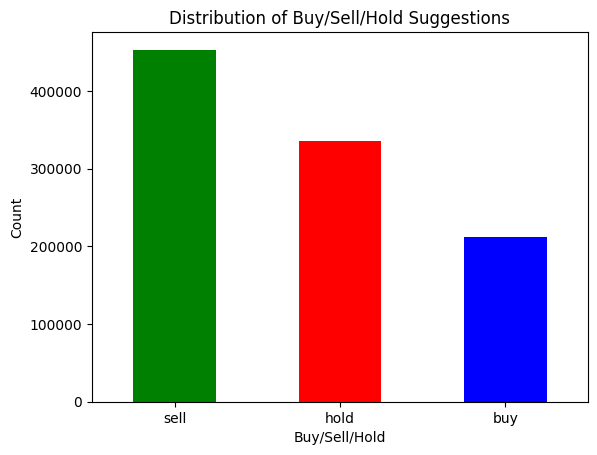

In [ ]:
# Plotting the distribution of buy_sell_suggestions
buy_sell_distribution = sample_tweets['buy_sell_suggestion'].value_counts()

# Create a bar chart
buy_sell_distribution.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of Buy/Sell/Hold Suggestions')
plt.xlabel('Buy/Sell/Hold')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate the x-axis labels to show them horizontally
plt.show()

In [ ]:
# First, let's make sure 'datetime' is a datetime object
sample_tweets['datetime'] = pd.to_datetime(sample_tweets[['year', 'month', 'day']])

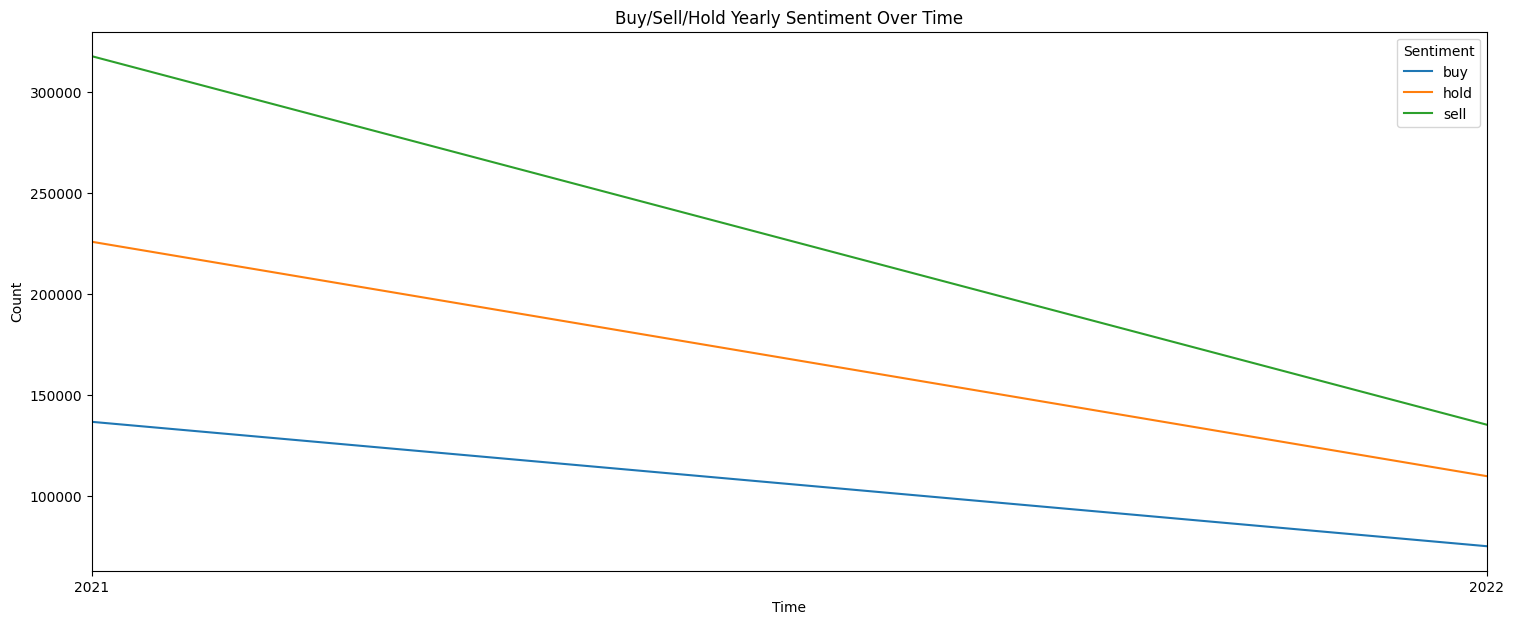

In [ ]:
# Group by 'datetime' and 'buy_sell_suggestion', and then count the occurrences
time_sentiment_count = sample_tweets.groupby([sample_tweets['datetime'].dt.to_period('D'), 'buy_sell_suggestion']).size().unstack(fill_value=0)

# Here, 'Y' is used for yearly.
time_sentiment_count = time_sentiment_count.resample('Y').sum()

# Plot the time series
time_sentiment_count.plot(kind='line', figsize=(18, 7))
plt.title('Buy/Sell/Hold Yearly Sentiment Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

This chart shows a consistent decline in all three categories over the year.
The 'sell' sentiment starts highest and remains the most frequent suggestion throughout the year, suggesting a predominant inclination towards selling.
The 'buy' sentiment, while lower than 'sell', is still higher than 'hold', indicating more optimism than neutrality or indecision.The 'hold' sentiment is the least frequent, which may suggest a dynamic market environment where indecision is less common.

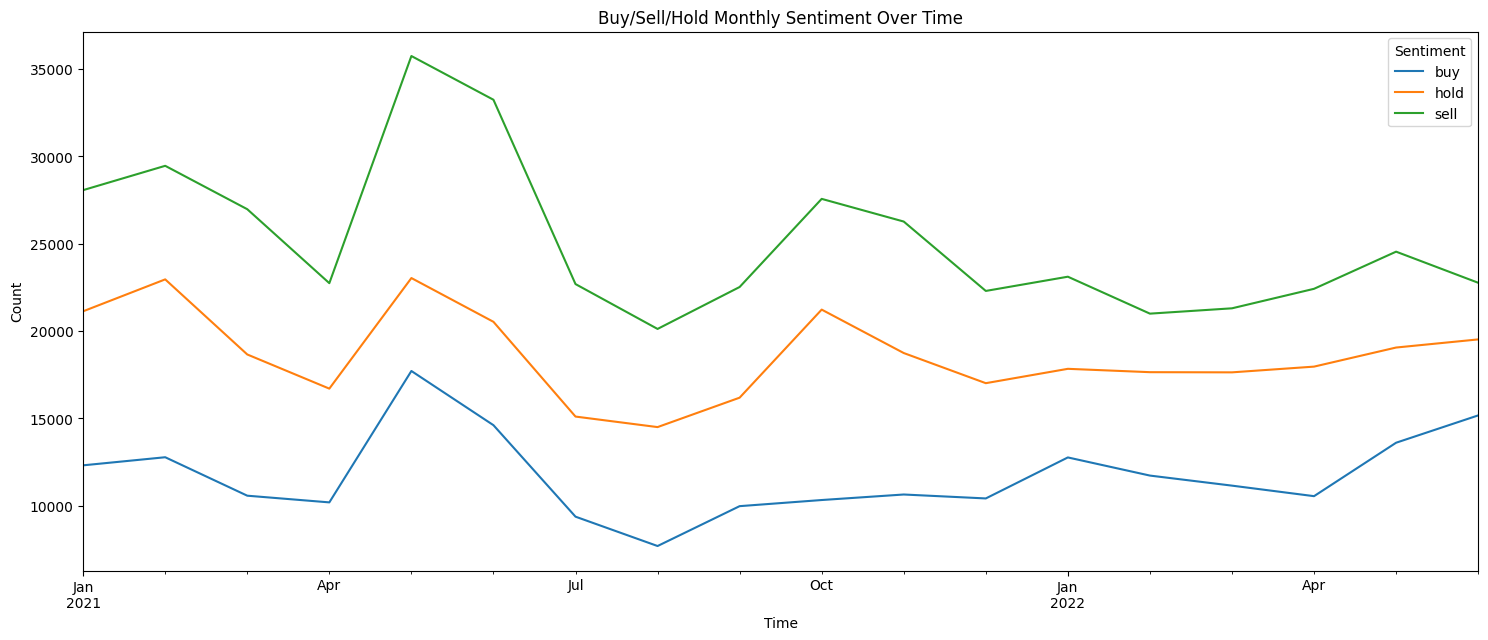

In [ ]:
# Group by 'datetime' and 'buy_sell_suggestion', and then count the occurrences
time_sentiment_count = sample_tweets.groupby([sample_tweets['datetime'].dt.to_period('D'), 'buy_sell_suggestion']).size().unstack(fill_value=0)

# Here, 'M' is used for monthly.
time_sentiment_count = time_sentiment_count.resample('M').sum()

# Plot the time series
time_sentiment_count.plot(kind='line', figsize=(18, 7))
plt.title('Buy/Sell/Hold Monthly Sentiment Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

The monthly chart shows more variation compared to the yearly chart.
There are noticeable peaks and troughs, indicating specific months where sentiments were particularly high or low. The 'sell' sentiment shows significant peaks, suggesting periods of strong selling recommendations. The 'buy' sentiment also shows variability but doesn't peak as high as 'sell', possibly indicating less aggressive buying recommendations. The 'hold' sentiment is less volatile than the other two, which may indicate a consistent level of indecision or neutrality month-to-month.

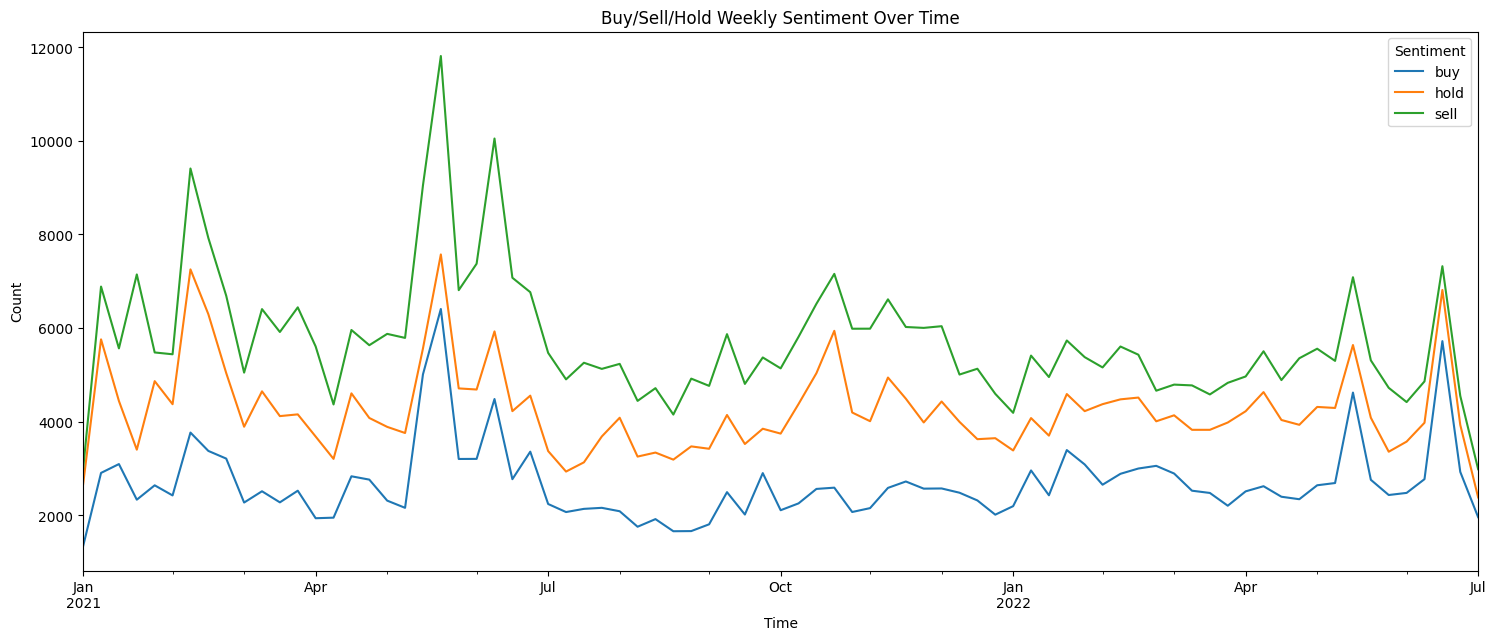

In [ ]:
# Group by 'datetime' and 'buy_sell_suggestion', and then count the occurrences
time_sentiment_count = sample_tweets.groupby([sample_tweets['datetime'].dt.to_period('D'), 'buy_sell_suggestion']).size().unstack(fill_value=0)

# Here, 'W' is used for weekly.
time_sentiment_count = time_sentiment_count.resample('W').sum()

# Plot the time series
time_sentiment_count.plot(kind='line', figsize=(18, 7))
plt.title('Buy/Sell/Hold Weekly Sentiment Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

The weekly chart shows even more fluctuation, which is expected as it captures the weekly market sentiment changes.There are sharp spikes, particularly in the 'sell' sentiment, which could correspond to weekly events or news impacting sentiment. The 'buy' sentiment appears to follow the 'sell' sentiment but with less intensity. The 'hold' sentiment shows less drastic changes, suggesting a relatively steady level of neutrality on a week-to-week basis

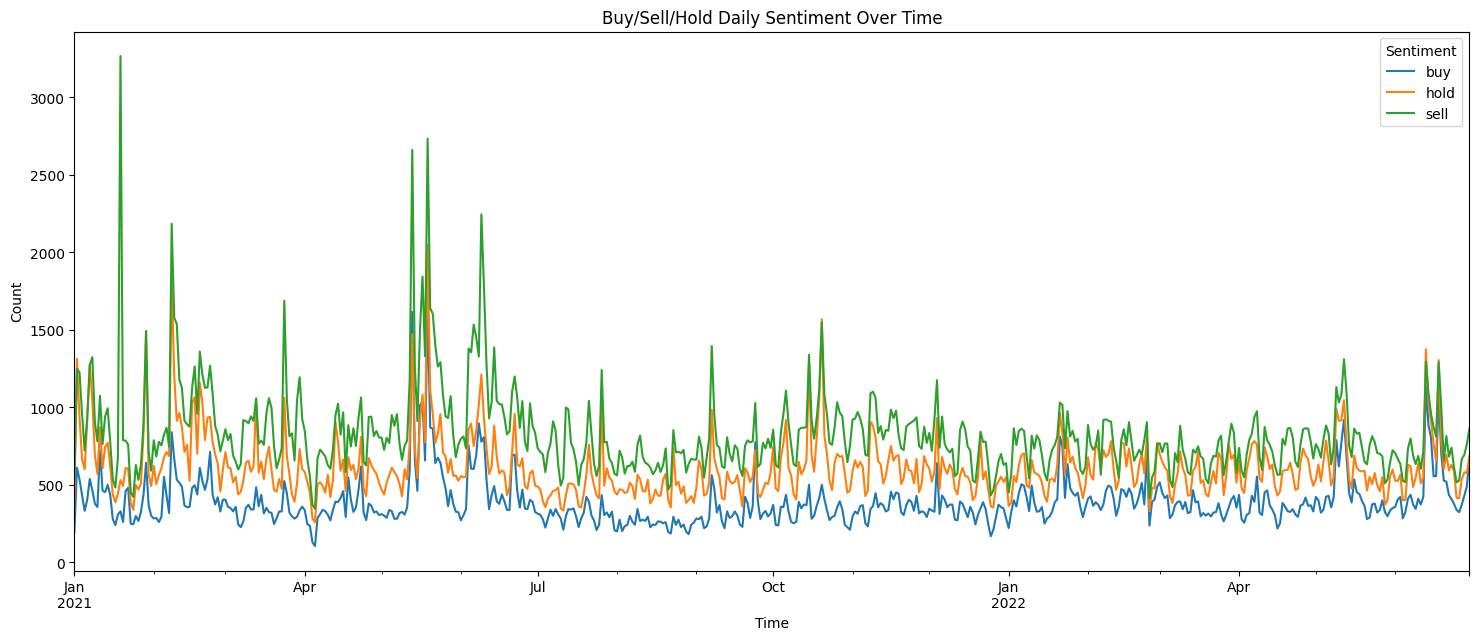

In [ ]:
# Group by 'datetime' and 'buy_sell_suggestion', and then count the occurrences
time_sentiment_count = sample_tweets.groupby([sample_tweets['datetime'].dt.to_period('D'), 'buy_sell_suggestion']).size().unstack(fill_value=0)

# Here, 'D' is used for daily.
time_sentiment_count = time_sentiment_count.resample('D').sum()

# Plot the time series
time_sentiment_count.plot(kind='line', figsize=(18, 7))
plt.title('Buy/Sell/Hold Daily Sentiment Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

The daily chart is the most volatile, with sharp and frequent fluctuations in all three sentiments. This is indicative of the daily response to news or market conditions that can rapidly change public sentiment. The 'sell' sentiment, while fluctuating, does not reach the same highs as on the weekly chart, suggesting that extreme selling recommendations may be less common on a day-to-day basis. The 'buy' and 'hold' sentiments fluctuate almost in tandem, suggesting that daily decisions between buying and holding are more closely related.

Across all time frames, the 'sell' sentiment is generally dominant, implying a trend towards selling recommendations in the dataset.The 'buy' sentiment, while present, is less prominent than 'sell', indicating fewer instances where buying is encouraged. The 'hold' sentiment is consistently the least frequent, which could suggest that the context of the dataset leans towards active trading rather than holding. The variability in sentiments increases as the time frame shortens, with the daily chart showing the most volatility, reflecting the immediate reactions to short-term market events or news. The overall trend suggests a dynamic sentiment environment where public opinion shifts in response to ongoing developments, with a general inclination towards selling over the observed period.

In [ ]:
# Define function for wordcloud
def create_wordcloud(text):
    words=' '.join([words for words in text])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

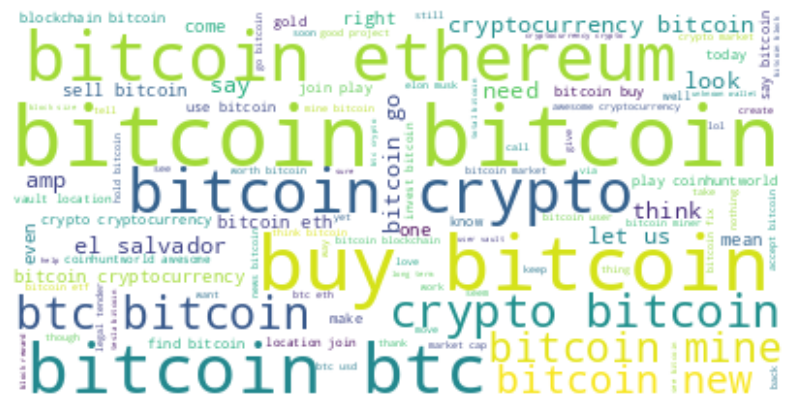

In [ ]:
# wordcloud for all tweets
create_wordcloud(sample_tweets["cleaned_tweet"].values)

Great, now that we have sentiments, we can move ahead with modelling. Please note that, it is NOT an industry practice to reply on machine generated labels as ground truth and that this is only for learning purposes and so a single model serves the purpose.

In [ ]:
# distribution
sample_tweets['buy_sell_suggestion'].value_counts()

sell    452838
hold    335428
buy     211518
Name: buy_sell_suggestion, dtype: int64

In [ ]:
# Define a mapping dictionary
mapping_dict = {'buy': 1, 'sell': 2, 'hold': 0}

# Map the 'buy_sell_suggestion' column using the dictionary
sample_tweets['buy_sell_suggestion_mapped'] = sample_tweets['buy_sell_suggestion'].map(mapping_dict)

# Check the first few rows of the DataFrame to confirm the mapping
sample_tweets.head()

,year,month,day,time,datetime,username,tweet,cleaned_tweet,sentiment,buy_sell_suggestion,buy_sell_suggestion_mapped
0,2022,6,22,17:20:08,2022-06-22,dasrecord,@allen_drewe @financebrah2 @newzealandhodl @florida_btc @ln_prints @awaitedsavior @ropeium @theguyswann @downwarddave @davidgshort @rangershodl @based_fyodor @federalistfiles @notephesians @mr_vril_maxxed @bitcoin_fuckboi @andhans_jail @janetystackx @joshmanmode_ you mean your fiat is slowly dying.,drewe btc print fyodor vril maxxed fuckboi jail mean fiat slowly die,-0.5994,buy,1
1,2021,7,4,17:35:49,2021-07-04,CryptoEugene101,"@themoonboyz \n\n$qnt “the image below explains \n what quant is all about!”\n\n“expect a parabolic breakout!”\n\n“$qnt is all around us &amp; the majority don’t even realise/ know it yet, but soon they will!”\n\n@quant_network @quantoverledger \n@ripple @bitcoin https://t.co/nqqfe8fw6c",image explain quant expect parabolic breakout around us amp majority not even realise know yet soon network,0.0000,hold,0
2,2021,9,8,17:05:41,2021-09-08,BotcoinUSD,on the 09/08/2021 at 05:05 1btc was worth $46377.00 #bitcoin #crypto #botcoinusd #bitfinex,btc worth bitcoin crypto botcoinusd bitfinex,0.2263,sell,2
3,2021,4,23,09:49:48,2021-04-23,emylacapra,"@shanstory the best position is to love both when it goes up or down😉\nit's never enough of bitcoin bought, don't you think?",best position love go never enough bitcoin buy not think,0.8555,sell,2
4,2021,5,3,04:14:42,2021-05-03,x_rhodium,@xrpology you’ll have to forgive me because it’s a fight to the bitter end. the evolution and the revolution continue on side-by-side. \nquestion on your preference:\nphysical gold\nbitcoin \nfiat\nor xrp\nwhich would give you the most comfort sleeping at night,forgive fight bitter end evolution revolution continue side side question preference physical gold bitcoin fiat xrp would give comfort sleep night,-0.2023,buy,1


In [ ]:
# Rename columns
sample_tweets = sample_tweets.rename(columns={
    'buy_sell_suggestion_mapped': 'category_mapped',
    'buy_sell_suggestion': 'category'
})

# confirm
sample_tweets.head()

,year,month,day,time,datetime,username,tweet,cleaned_tweet,sentiment,category,category_mapped
0,2022,6,22,17:20:08,2022-06-22,dasrecord,@allen_drewe @financebrah2 @newzealandhodl @florida_btc @ln_prints @awaitedsavior @ropeium @theguyswann @downwarddave @davidgshort @rangershodl @based_fyodor @federalistfiles @notephesians @mr_vril_maxxed @bitcoin_fuckboi @andhans_jail @janetystackx @joshmanmode_ you mean your fiat is slowly dying.,drewe btc print fyodor vril maxxed fuckboi jail mean fiat slowly die,-0.5994,buy,1
1,2021,7,4,17:35:49,2021-07-04,CryptoEugene101,"@themoonboyz \n\n$qnt “the image below explains \n what quant is all about!”\n\n“expect a parabolic breakout!”\n\n“$qnt is all around us &amp; the majority don’t even realise/ know it yet, but soon they will!”\n\n@quant_network @quantoverledger \n@ripple @bitcoin https://t.co/nqqfe8fw6c",image explain quant expect parabolic breakout around us amp majority not even realise know yet soon network,0.0000,hold,0
2,2021,9,8,17:05:41,2021-09-08,BotcoinUSD,on the 09/08/2021 at 05:05 1btc was worth $46377.00 #bitcoin #crypto #botcoinusd #bitfinex,btc worth bitcoin crypto botcoinusd bitfinex,0.2263,sell,2
3,2021,4,23,09:49:48,2021-04-23,emylacapra,"@shanstory the best position is to love both when it goes up or down😉\nit's never enough of bitcoin bought, don't you think?",best position love go never enough bitcoin buy not think,0.8555,sell,2
4,2021,5,3,04:14:42,2021-05-03,x_rhodium,@xrpology you’ll have to forgive me because it’s a fight to the bitter end. the evolution and the revolution continue on side-by-side. \nquestion on your preference:\nphysical gold\nbitcoin \nfiat\nor xrp\nwhich would give you the most comfort sleeping at night,forgive fight bitter end evolution revolution continue side side question preference physical gold bitcoin fiat xrp would give comfort sleep night,-0.2023,buy,1


Let's create a balanced dataset for modelling.

In [ ]:
# Determine the number of samples per class based on the smallest class
num_samples_per_class = min(sample_tweets['category_mapped'].value_counts())

# Sample an equal number of tweets from each sentiment category
balanced_sample = (sample_tweets.groupby('category_mapped').apply(lambda x: x.sample(num_samples_per_class)).reset_index(drop=True))

# Shuffle the dataset
balanced_sample = balanced_sample.sample(frac=1).reset_index(drop=True)

# Print the shape of the balanced dataset
print("Shape of balanced dataset:", balanced_sample.shape)

Shape of balanced dataset: (634554, 11)


In [ ]:
balanced_sample.head()

,year,month,day,time,datetime,username,tweet,cleaned_tweet,sentiment,category,category_mapped
0,2021,8,3,03:11:20,2021-08-03,BrieflyBitcoin,bank of america sees benefit in adopting #bitcoin as legal tender in el salvador\n\nsentiment: positive\n\nbank of america has outlined some benefits to be had from adopting bitcoin as legal tender in el...\n\nbrief: https://t.co/ccximkcipr\nhttps://t.co/hbwqfpixxt,bank america see benefit adopt bitcoin legal tender el salvador sentiment positive bank america outline benefit adopt bitcoin legal tender el brief,0.9186,sell,2
1,2022,5,2,14:54:32,2022-05-02,cryptoredline,@mikealfred since 2016 i have bitcoin and ethereum. waiting for that day that bitcoin gonna evolve like ethereum automatic contracts.,since bitcoin ethereum wait day bitcoin go evolve like ethereum automatic contract,0.3612,sell,2
2,2022,6,26,20:50:11,2022-06-26,WTFutures,"#etc is creating new resistance zones after destroying the 5, 15, 1 hour and 4 hour resistance zones.\n\n$etc #etcusdt #bitcoin #ethereum #crypto https://t.co/3pgxn9doty",etc create new resistance zone destroy hour hour resistance zone etcusdt bitcoin ethereum crypto,-0.3400,buy,1
3,2022,1,10,00:02:55,2022-01-10,ConnNFT,"who's buying #bitcoin ? is this the dip to be buying, or are we going lower? #eth #btc #cryptocurrency",buy bitcoin dip buy go lower eth btc cryptocurrency,-0.2960,buy,1
4,2021,3,10,01:14:06,2021-03-10,JimBob30238733,@ryanfeepoker ryan how do u buy bitcoin ? i tried coinbase but they have no customer support which matters to me,ryan buy bitcoin try coinbase customer support matter,0.4215,sell,2


In [ ]:
# Save sample_tweets_sentiment on Google Drive
output_dir = '/content/gdrive/MyDrive/Capstone/Word2Vec/balance_sample/'

# Define the file name
file_name = 'balanced_sample.csv'

# Save the DataFrame to a CSV file in Google Drive
balanced_sample.to_csv(output_dir + file_name, index=False)

In [ ]:
# Retrieve in case of session crash
csv_path = '/content/gdrive/MyDrive/Capstone/Word2Vec/balance_sample/balanced_sample.csv'

# Load the DataFrame
balanced_sample = pd.read_csv(csv_path, lineterminator='\n')

# Check to confirm csv file retrieveted properly
balanced_sample.head()

,year,month,day,time,datetime,username,tweet,cleaned_tweet,sentiment,category,category_mapped
0,2021,8,3,03:11:20,2021-08-03,BrieflyBitcoin,bank of america sees benefit in adopting #bitcoin as legal tender in el salvador\n\nsentiment: positive\n\nbank of america has outlined some benefits to be had from adopting bitcoin as legal tender in el...\n\nbrief: https://t.co/ccximkcipr\nhttps://t.co/hbwqfpixxt,bank america see benefit adopt bitcoin legal tender el salvador sentiment positive bank america outline benefit adopt bitcoin legal tender el brief,0.9186,sell,2
1,2022,5,2,14:54:32,2022-05-02,cryptoredline,@mikealfred since 2016 i have bitcoin and ethereum. waiting for that day that bitcoin gonna evolve like ethereum automatic contracts.,since bitcoin ethereum wait day bitcoin go evolve like ethereum automatic contract,0.3612,sell,2
2,2022,6,26,20:50:11,2022-06-26,WTFutures,"#etc is creating new resistance zones after destroying the 5, 15, 1 hour and 4 hour resistance zones.\n\n$etc #etcusdt #bitcoin #ethereum #crypto https://t.co/3pgxn9doty",etc create new resistance zone destroy hour hour resistance zone etcusdt bitcoin ethereum crypto,-0.3400,buy,1
3,2022,1,10,00:02:55,2022-01-10,ConnNFT,"who's buying #bitcoin ? is this the dip to be buying, or are we going lower? #eth #btc #cryptocurrency",buy bitcoin dip buy go lower eth btc cryptocurrency,-0.2960,buy,1
4,2021,3,10,01:14:06,2021-03-10,JimBob30238733,@ryanfeepoker ryan how do u buy bitcoin ? i tried coinbase but they have no customer support which matters to me,ryan buy bitcoin try coinbase customer support matter,0.4215,sell,2


In [ ]:
# sentiment_label distribution
balanced_sample['category_mapped'].value_counts()

2    211518
1    211518
0    211518
Name: category_mapped, dtype: int64

In [ ]:
# check for null values
balanced_sample.isnull().sum()

year               0
month              0
day                0
time               0
datetime           0
username           0
tweet              0
cleaned_tweet      0
sentiment          0
category           0
category_mapped    0
dtype: int64

In [ ]:
# Retriving tweet vectors
def tweet_to_vector(tweet, model):
    """
    Convert a tweet into a vector by averaging the vectors of the words in the tweet.
    Only considers words found in the Word2Vec model.
    """
    words = tweet.split()
    word_vectors = [model[word] for word in words if word in model]

    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)  # Return zero vector for tweets with no known words

    tweet_vector = np.mean(word_vectors, axis=0)
    return tweet_vector

In [ ]:
# Apply the function to each tweet in the cleaned_tweets column
balanced_sample['tweet_vectors'] = balanced_sample['cleaned_tweet'].apply(lambda tweet: tweet_to_vector(tweet, word_vectors))

In [ ]:
# Let's look at how the corpus now looks
balanced_sample.head()

,year,month,day,time,datetime,username,tweet,cleaned_tweet,sentiment,category,category_mapped,tweet_vectors
0,2021,8,3,03:11:20,2021-08-03,BrieflyBitcoin,bank of america sees benefit in adopting #bitcoin as legal tender in el salvador\n\nsentiment: positive\n\nbank of america has outlined some benefits to be had from adopting bitcoin as legal tender in el...\n\nbrief: https://t.co/ccximkcipr\nhttps://t.co/hbwqfpixxt,bank america see benefit adopt bitcoin legal tender el salvador sentiment positive bank america outline benefit adopt bitcoin legal tender el brief,0.9186,sell,2,"[-0.31757963, 0.10027568, -0.18486142, 0.27022764, -0.30134994, -0.38617507, 0.48621866, -0.0392156, -0.37568533, 0.5557653, -0.19783793, 0.29374945, -0.22247358, 0.2724683, -0.29320556, 0.003506148, -0.09278678, -0.10836677, 0.09715244, 0.057639543, 0.082856685, -0.2781556, -0.51773775, 0.30948544, 0.65171766, -0.24084908, 0.0652338, -0.3943559, 0.26814988, -0.22659789, -0.31601217, 0.35197085, 0.024741167, 0.26318204, -0.40569392, 0.4546963, 0.5860167, -0.052838065, -0.16127849, -0.016003568, -0.1362899, 0.80284154, 0.42292973, 0.10516384, 0.16225697, -0.07398022, 0.24760772, 0.2352034, 0.08290778, 0.094879396, -0.31740168, -0.2028133, -0.009542248, -0.4568389, -0.3029766, -0.07434887, 0.2584601, -0.08130305, -0.243187, -0.18916583, -0.13718772, -0.26407224, -0.24135837, -0.6343556, -0.3960992, 0.25964078, -0.45786107, 0.07807756, 0.65233094, 0.07569515, 0.14181651, -0.16827683, -0.8551369, 0.46375445, -0.3534043, 0.4788126, -0.23103791, -0.3190148, 0.19220176, -0.1396474, -0.2176583, -0.24178539, 0.22212793, -0.6572778, 0.5605245, -0.053591337, -0.005429076, 0.13997956, -0.18096934, 0.29484892, 0.13080412, -0.019116329, -0.24855423, -0.07449687, -0.2350306, -0.3966223, -0.22975007, -0.007913248, -0.06586118, 0.23467709, ...]"
1,2022,5,2,14:54:32,2022-05-02,cryptoredline,@mikealfred since 2016 i have bitcoin and ethereum. waiting for that day that bitcoin gonna evolve like ethereum automatic contracts.,since bitcoin ethereum wait day bitcoin go evolve like ethereum automatic contract,0.3612,sell,2,"[-0.10168886, 0.4265832, 0.15867133, -0.22985274, -0.14782415, 0.2877655, 0.16921157, -0.27537066, -0.0054776673, 0.4612004, -0.074967414, 0.055453226, 0.2761586, 0.17280968, -0.2743882, -0.12571622, 0.08312902, -0.13759176, 0.053562477, 0.08802538, 0.2225614, -0.023313373, -0.057896044, -0.019568542, 0.018169656, -0.06721466, 0.07735599, -0.16077049, 0.039504636, 0.31591484, 0.16565955, -0.05622993, 0.22993205, 0.16813743, -0.10887375, 0.2970632, 0.15919578, 0.121792115, -0.13393961, -0.069875926, 0.057508606, 0.039911043, 0.19690506, 0.27575603, -0.34892786, 0.16240792, -0.03567859, 0.15913562, 0.043926317, -0.017816233, -0.19501932, -0.029875046, 0.28590348, 0.27713594, 0.09825667, 0.25581747, 0.35821006, 0.53111947, 0.122411095, 0.15735693, 0.29496908, -0.49724695, 0.036332015, -0.31652024, -0.06126079, 0.16243862, -0.3142546, -0.10574919, 0.28747228, 0.06674679, -0.32460558, -0.030161798, 0.068641506, 0.23402826, 0.04371353, 0.49774554, -0.13594066, 0.10482743, -0.3159905, -0.035676297, 0.1481935, 0.28270343, 0.04834001, -0.13969897, -0.10042733, 0.18927307, -0.13570593, 0.12446181, 0.23531039, -0.14519866, -0.27160615, 0.14706036, -0.07686175, 0.3184584, 0.2606872, -0.044337552, 0.13875161, 0.30160066, -0.46670935, -0.2510846, ...]"
2,2022,6,26,20:50:11,2022-06-26,WTFutures,"#etc is creating new resistance zones after destroying the 5, 15, 1 hour and 4 hour resistance zones.\n\n$etc #etcusdt #bitcoin #ethereum #crypto https://t.co/3pgxn9doty",etc create new resistance zone destroy hour hour resistance zone etcusdt bitcoin ethereum crypto,-0.3400,buy,1,"[0.29176408, 0.23502524, 0.27072465, -0.27839598, 0.059813697, -0.17983775, 0.098861985, -0.42544803, -0.18222415, 0.05642521, -0.036387034, -0.1818353, -0.06487212, -0.16948138, -0.4846306, 0.14163485, 0.021915352, -0.0016945346, -0.38594896, 0.045236085, 0.4267651, -0.056001246, -0.06896498, 0.24250484,

In [ ]:
# We'll have to use pickle file format for this as csv will not be able to display the tweet_vectors column in the right format.
# Save sample_tweets_sentiment on Google Drive
balanced_sample.to_pickle('/content/gdrive/MyDrive/Capstone/Word2Vec/balance_sample/balanced_sample.pkl')

In [ ]:
# Retrieve in case of session crash
balanced_sample = pd.read_pickle('/content/gdrive/MyDrive/Capstone/Word2Vec/balance_sample/balanced_sample.pkl')

In [ ]:
# Let's make sure the file got retrieved properly
balanced_sample.head()

,year,month,day,time,datetime,username,tweet,cleaned_tweet,sentiment,category,category_mapped,tweet_vectors
0,2021,8,3,03:11:20,2021-08-03,BrieflyBitcoin,bank of america sees benefit in adopting #bitc...,bank america see benefit adopt bitcoin legal t...,0.9186,sell,2,"[-0.31757963, 0.10027568, -0.18486142, 0.27022..."
1,2022,5,2,14:54:32,2022-05-02,cryptoredline,@mikealfred since 2016 i have bitcoin and ethe...,since bitcoin ethereum wait day bitcoin go evo...,0.3612,sell,2,"[-0.10168886, 0.4265832, 0.15867133, -0.229852..."
2,2022,6,26,20:50:11,2022-06-26,WTFutures,#etc is creating new resistance zones after d...,etc create new resistance zone destroy hour ho...,-0.3400,buy,1,"[0.29176408, 0.23502524, 0.27072465, -0.278395..."
3,2022,1,10,00:02:55,2022-01-10,ConnNFT,who's buying #bitcoin ? is this the dip to be ...,buy bitcoin dip buy go lower eth btc cryptocur...,-0.2960,buy,1,"[-0.00104879, 0.30820906, 0.2549957, -0.111654..."
4,2021,3,10,01:14:06,2021-03-10,JimBob30238733,@ryanfeepoker ryan how do u buy bitcoin ? i tr...,ryan buy bitcoin try coinbase customer support...,0.4215,sell,2,"[-0.18221024, 0.17337537, -0.13183504, -0.2366..."


In [ ]:
# Preparing X and y for modeling
X = np.array(balanced_sample['tweet_vectors'].tolist())  # Convert the list of vectors to a NumPy array
y = balanced_sample['category_mapped']

In [ ]:
# Splitting Data into Training, Validation, and Testing Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Best Parameters: {'C': 10}
Validation Accuracy: 0.680941762337386
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.71      0.71     42431
           1       0.67      0.69      0.68     42386
           2       0.67      0.64      0.66     42094

    accuracy                           0.68    126911
   macro avg       0.68      0.68      0.68    126911
weighted avg       0.68      0.68      0.68    126911

Test Accuracy: 0.6773959704044566
Test Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.71      0.70     42409
           1       0.67      0.69      0.68     42191
           2       0.67      0.64      0.65     42311

    accuracy                           0.68    126911
   macro avg       0.68      0.68      0.68    126911
weighted avg       0.68      0.68      0.68    126911



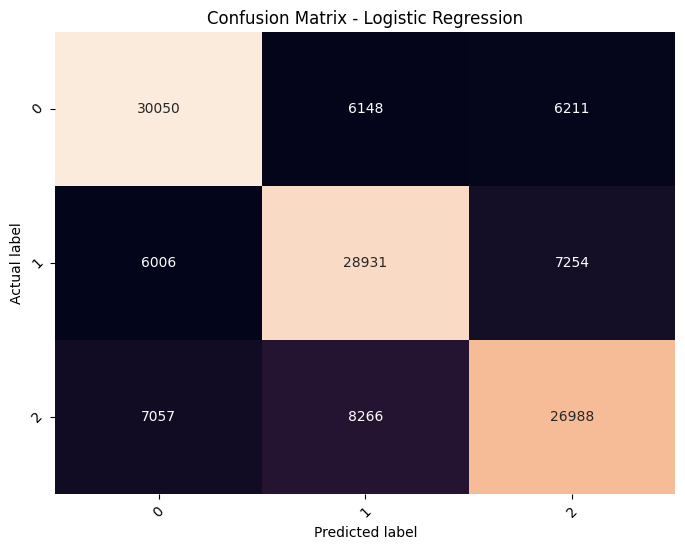

In [ ]:
# Model Selection
model = LogisticRegression(max_iter=1000, random_state=42)

# Model Training
model.fit(X_train, y_train)

# Hyperparameter Tuning (on Validation Set)
parameters = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(model, parameters, cv=5, scoring='accuracy')
grid_search.fit(X_val, y_val)
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Validation of the Model
y_val_pred = best_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

# Final Evaluation on the Test Set
y_test_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

# Confusion Matrix for Test Set
conf_mat = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))

# Using seaborn to create a more informative confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='g', cbar=False)

# Adding labels, title, and ticks
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks + 0.5, np.unique(y), rotation=45)
plt.yticks(tick_marks + 0.5, np.unique(y), rotation=45)
plt.show()